In [18]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
from typing import Tuple, Optional
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm, trange
import seaborn as sns
import gc
import time
import warnings
from collections import deque
import psutil
import os

In [19]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [137]:
FILE_PATH = '/mnt/sda3/dataset_AMC /radioml2018/versions/2/GOLD_XYZ_OSC.0001_1024.hdf5'
JSON_PATH = '/mnt/sda3/dataset_AMC /radioml2018/versions/2/classes-fixed.json'

TARGET_MODULATIONS = ['OOK','4ASK', 'BPSK', 'QPSK', '8PSK','32PSK', '16QAM' ]
#TARGET_MODULATIONS = ['OOK','4ASK','BPSK', 'QPSK', '8PSK','16QAM','GMSK']
BATCH_SIZE = 128 # adjust to my laptop 
#LEARNING_RATE = 0.003 
NUM_EPOCHS = 300 
NUM_WORKERS = 0 #Temporary check it  

INPUT_CHANNELS = 2 
SEQUENCE_LENGTH = 1024 
NUM_CLASSES = 7 # adjust this to 

patience = 25
# TRAIN_RATIO = 0.7 
# VALID_RATIO = 0.2 
# TEST_RATIO = 0.1 

nf_train = int(BATCH_SIZE * 0.7)
nf_valid = int(BATCH_SIZE * 0.2)
nf_test  = BATCH_SIZE - nf_train - nf_valid

print("📋 Training Parameters:")
print(f"  Batch size: {BATCH_SIZE}")
#print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")

📋 Training Parameters:
  Batch size: 128
  Epochs: 300


In [138]:
def dataset_split(data,
                  modulations_classes,
                  modulations,
                  snrs,
                  target_modulations,
                  mode,
                  target_snrs,
                  train_proportion=0.8, # training 70 %
                  valid_proportion=0.2, # validation 20 %
                  test_proportion=0.0, # testing 10 % 
                  seed=48):
    np.random.seed(seed)
    X_output = []
    Y_output = []
    Z_output = []                                   

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]

    for modu in target_modulation_indices:
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]

            np.random.shuffle(snr_modu_indices)
            num_samples = len(snr_modu_indices)
            train_end = int(train_proportion * num_samples)
            valid_end = int((train_proportion + valid_proportion) * num_samples)

            if mode == 'train':
                indices = snr_modu_indices[:train_end]
            elif mode == 'valid':
                indices = snr_modu_indices[train_end:valid_end]
            elif mode == 'test':
                indices = snr_modu_indices[valid_end:]
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test')

            X_output.append(data[np.sort(indices)])
            Y_output.append(modulations[np.sort(indices)])
            Z_output.append(snrs[np.sort(indices)])

    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index, value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array == value] = index
    return X_array, Y_array, Z_array

In [139]:
class RadioMLIQDataset(Dataset):
    """Dataset class for RadioML18 data formatted for CNNIQModel dual-branch architecture.
    
    Loads RadioML18 HDF5 data and returns separate I and Q tensors in 2D format
    suitable for CNNIQModel's separate branch processing.
    """
    
    def __init__(self, mode: str, use_fft: bool = False, seed: int = 48):
        """Initialize RadioMLIQDataset.
        
        Args:
            mode: Dataset split mode ('train', 'valid', or 'test').
            use_fft: Whether to apply FFT transformation to signals.
            seed: Random seed for dataset splitting.
            
        Raises:
            FileNotFoundError: If HDF5 or JSON files cannot be found.
            ValueError: If mode is not valid or data dimensions are incompatible.
        """
        super(RadioMLIQDataset, self).__init__()
        
        # Configuration (you'll need to define these constants)
        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft
        self.mode = mode
        
        # Validate mode
        if mode not in ['train', 'valid', 'test']:
            raise ValueError(f"Mode must be 'train', 'valid', or 'test', got '{mode}'")
        
        # Load data files
        try:
            self.hdf5_file = h5py.File(self.file_path, 'r')
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Error loading data files: {e}")
        except Exception as e:
            print(f"Error loading file: {e}")
            raise e
        
        # Load raw data
        self.X = self.hdf5_file['X']
        self.Y = np.argmax(self.hdf5_file['Y'], axis=1)
        self.Z = self.hdf5_file['Z'][:, 0]
        
        # Calculate proportions for dataset splitting
        train_proportion = (7 * 26 * nf_train) / self.X.shape[0]
        valid_proportion = (7 * 26 * nf_valid) / self.X.shape[0]
        test_proportion = (7 * 26 * nf_test) / self.X.shape[0]
        
        self.target_snrs = np.unique(self.Z)
        
        # Split dataset
        self.X_data, self.Y_data, self.Z_data = dataset_split(
            data=self.X,
            modulations_classes=self.modulation_classes,
            modulations=self.Y,
            snrs=self.Z,
            mode=mode,
            train_proportion=train_proportion,
            valid_proportion=valid_proportion,
            test_proportion=test_proportion,
            target_modulations=self.target_modulations,
            target_snrs=self.target_snrs,
            seed=seed
        )
        
        # Apply I/Q swap correction for AMC compatibility
        # print(f"🔧 Applying I/Q swap fix to {mode} dataset...")
        self.X_data = self.X_data[:, :, [0, 1]]
        # print(f"✅ I/Q channels corrected for real-world compatibility")
        
        # Validate signal length for 2D reshaping
        signal_length = self.X_data.shape[1]
        if signal_length != 1024:
            raise ValueError(f"Expected signal length 1024 for 32x32 reshape, got {signal_length}")
        
        if self.use_fft:
            print("Dataset configured to use FFT as input")
        
        # Store dataset statistics
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]
        
        print(f"RadioMLIQDataset {mode}: {self.num_data} samples, "
              f"{self.num_lbl} classes, {self.num_snr} SNR levels")
    
    def __len__(self) -> int:
        """Return the number of samples in the dataset.
        
        Returns:
            Number of samples.
        """
        return self.X_data.shape[0]
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int, float]:
        """Get a sample from the dataset.
        
        Args:
            idx: Sample index.
            
        Returns:
            Tuple of (i_tensor, q_tensor, label, snr) where:
                - i_tensor: I signal as 2D tensor (1, 32, 32)
                - q_tensor: Q signal as 2D tensor (1, 32, 32) 
                - label: Modulation class label
                - snr: Signal-to-noise ratio
                
        Raises:
            IndexError: If idx is out of range.
        """
        if idx >= len(self) or idx < 0:
            raise IndexError(f"Index {idx} out of range for dataset of size {len(self)}")
        
        # Get raw data
        x_raw, y, z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        
        # Convert to tensor and transpose to (channels, sequence_length)
        x = torch.from_numpy(x_raw).float().transpose(0, 1)  # Shape: (2, 1024)
        
        # Apply FFT if requested
        if self.use_fft:
            complex_signal = torch.complex(x[0], x[1])
            fft_result = torch.fft.fft(complex_signal)
            fft_real = torch.real(fft_result)
            fft_imag = torch.imag(fft_result)
            x = torch.stack([fft_real, fft_imag], dim=0)
        
        # Separate I and Q signals
        i_signal = x[0]  # Shape: (1024,)
        q_signal = x[1]  # Shape: (1024,)
        
        amplitude = torch.sqrt(i_signal**2 + q_signal**2)
        phase = torch.atan2(q_signal, i_signal)
        
        i_2d = amplitude.view(1, 32, 32)  # Amplitude as "I"
        q_2d = phase.view(1, 32, 32)     # Phase as "Q"
        
        return i_2d, q_2d, y, z
    
    def get_signal_stats(self) -> dict:
        """Get statistics about the signals in the dataset.
        
        Returns:
            Dictionary with signal statistics.
        """
        # Sample a few signals to compute stats
        sample_indices = np.random.choice(len(self), min(1000, len(self)), replace=False)
        i_values = []
        q_values = []
        
        for idx in sample_indices:
            i_2d, q_2d, _, _ = self[idx]
            i_values.append(i_2d.flatten())
            q_values.append(q_2d.flatten())
        
        i_all = torch.cat(i_values)
        q_all = torch.cat(q_values)
        
        return {
            'i_mean': float(i_all.mean()),
            'i_std': float(i_all.std()),
            'i_min': float(i_all.min()),
            'i_max': float(i_all.max()),
            'q_mean': float(q_all.mean()),
            'q_std': float(q_all.std()),
            'q_min': float(q_all.min()),
            'q_max': float(q_all.max()),
            'signal_shape': '(1, 32, 32)',
            'num_samples': len(self)
        }
    
    def close(self):
        """Close the HDF5 file handle."""
        if hasattr(self, 'hdf5_file'):
            self.hdf5_file.close()
    
    def __del__(self):
        """Cleanup when object is destroyed."""
        self.close()

In [140]:
try:
    from CNN_IQ import create_CNNIQModel

    # Match the real signature: (n_labels, dropout_rate)
    model_CNNIQ = create_CNNIQModel(n_labels=NUM_CLASSES, dropout_rate=0.3).to(device)
    print("✅ Successfully built CNNIQModel:", model_CNNIQ)

except Exception as e:
    print(f"⚠️ Could not build CNNIQModel: {e}")

✅ Successfully built CNNIQModel: CNNIQModel(
  (i_branch): CNNIQBranch(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (leaky_relu): LeakyReLU(negative_slope=0.1, inplace=True)
    (dropout): Dropout2d(p=0.22499999999999998, inplace=False)
    (global_avg_pool): A

/tmp/ipykernel_3185/3046425438.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
RadioMLIQDataset train: 4550 samples, 7 classes, 26 SNR levels
RadioMLIQDataset train: 4550 samples, 7 classes, 26 SNR levels
RadioMLIQDataset valid: 1456 samples, 7 classes, 26 SNR levels
Datasets loaded successfully.
Total dataset size: 4550
Train dataset size: 4550 (80%)
Validation dataset size: 1456 (20%)

Starting training...


Training:   0%|                      | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_3185/3046425438.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training:  58%|███████▌     | 21/36 [00:01<00:00, 20.76it/s]
                                                            
Validation:   0%|                    | 0/12 [00:00<?, ?it/s]
                                                            /home/lipplopp/anaconda3/envs/ai_sdr/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choos

Epoch 1/300: Train Loss: 3.5034 | Train Acc: 25.23% | Valid Loss: 1.9959 | Valid Acc: 23.83%



Training:  61%|███████▉     | 22/36 [00:01<00:00, 21.93it/s]
                                                            
Epochs:   1%|▏                                  | 2/300 [00:03<09:39,  1.94s/it]

Epoch 2/300: Train Loss: 2.0566 | Train Acc: 33.01% | Valid Loss: 1.5787 | Valid Acc: 44.23%



Training:  61%|███████▉     | 22/36 [00:01<00:00, 21.77it/s]
                                                            
Epochs:   1%|▎                                  | 3/300 [00:05<09:32,  1.93s/it]

Epoch 3/300: Train Loss: 1.8113 | Train Acc: 35.96% | Valid Loss: 1.5288 | Valid Acc: 43.96%



Training:  61%|███████▉     | 22/36 [00:01<00:00, 21.55it/s]
                                                            
Epochs:   1%|▍                                  | 4/300 [00:07<09:30,  1.93s/it]

Epoch 4/300: Train Loss: 1.6888 | Train Acc: 38.97% | Valid Loss: 1.4466 | Valid Acc: 45.19%



Training:  61%|███████▉     | 22/36 [00:01<00:00, 21.41it/s]
                                                            
Epochs:   2%|▌                                  | 5/300 [00:09<09:30,  1.94s/it]

Epoch 5/300: Train Loss: 1.6068 | Train Acc: 41.47% | Valid Loss: 1.3933 | Valid Acc: 47.80%



Training:  61%|███████▉     | 22/36 [00:01<00:00, 21.24it/s]
                                                            
Epochs:   2%|▋                                  | 6/300 [00:11<09:30,  1.94s/it]

Epoch 6/300: Train Loss: 1.5669 | Train Acc: 41.12% | Valid Loss: 1.4078 | Valid Acc: 44.99%



Training:  58%|███████▌     | 21/36 [00:01<00:00, 19.77it/s]
                                                            
Epochs:   2%|▊                                  | 7/300 [00:13<09:42,  1.99s/it]

Epoch 7/300: Train Loss: 1.5046 | Train Acc: 44.04% | Valid Loss: 1.3551 | Valid Acc: 50.89%



Training:  53%|██████▊      | 19/36 [00:01<00:00, 18.52it/s]
                                                            
Epochs:   3%|▉                                  | 8/300 [00:15<10:02,  2.06s/it]

Epoch 8/300: Train Loss: 1.4840 | Train Acc: 44.73% | Valid Loss: 1.3518 | Valid Acc: 50.07%



Training:  56%|███████▏     | 20/36 [00:01<00:00, 18.83it/s]
                                                            
Epochs:   3%|█                                  | 9/300 [00:18<10:14,  2.11s/it]

Epoch 9/300: Train Loss: 1.4670 | Train Acc: 45.19% | Valid Loss: 1.3416 | Valid Acc: 50.55%



Training:  50%|██████▌      | 18/36 [00:01<00:01, 17.18it/s]
                                                            
Epochs:   3%|█▏                                | 10/300 [00:20<10:31,  2.18s/it]

Epoch 10/300: Train Loss: 1.4608 | Train Acc: 44.53% | Valid Loss: 1.3332 | Valid Acc: 51.37%



Training:  53%|██████▊      | 19/36 [00:01<00:00, 17.94it/s]
                                                            
Epochs:   4%|█▏                                | 11/300 [00:22<10:51,  2.26s/it]

Epoch 11/300: Train Loss: 1.4497 | Train Acc: 45.85% | Valid Loss: 1.3181 | Valid Acc: 51.58%



Training:  94%|████████████▎| 34/36 [00:02<00:00, 16.07it/s]
                                                            
Epochs:   4%|█▎                                | 12/300 [00:25<11:10,  2.33s/it]

Epoch 12/300: Train Loss: 1.4296 | Train Acc: 47.10% | Valid Loss: 1.3170 | Valid Acc: 52.88%



Training:  92%|███████████▉ | 33/36 [00:02<00:00, 16.29it/s]
                                                            
Epochs:   4%|█▍                                | 13/300 [00:27<11:26,  2.39s/it]

Epoch 13/300: Train Loss: 1.4163 | Train Acc: 47.34% | Valid Loss: 1.3197 | Valid Acc: 50.82%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.54it/s]
                                                            
Epochs:   5%|█▌                                | 14/300 [00:30<11:46,  2.47s/it]

Epoch 14/300: Train Loss: 1.4091 | Train Acc: 47.85% | Valid Loss: 1.3111 | Valid Acc: 50.96%



Training: 100%|█████████████| 36/36 [00:02<00:00, 16.71it/s]
                                                            
Epochs:   5%|█▋                                | 15/300 [00:33<11:46,  2.48s/it]

Epoch 15/300: Train Loss: 1.4124 | Train Acc: 46.77% | Valid Loss: 1.2985 | Valid Acc: 52.54%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.56it/s]
                                                            
Epochs:   5%|█▊                                | 16/300 [00:35<11:58,  2.53s/it]

Epoch 16/300: Train Loss: 1.3997 | Train Acc: 47.19% | Valid Loss: 1.3051 | Valid Acc: 52.82%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:   6%|█▉                                | 17/300 [00:38<12:06,  2.57s/it]

Epoch 17/300: Train Loss: 1.3929 | Train Acc: 48.31% | Valid Loss: 1.2902 | Valid Acc: 52.68%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.54it/s]
                                                            
Epochs:   6%|██                                | 18/300 [00:41<12:11,  2.59s/it]

Epoch 18/300: Train Loss: 1.3891 | Train Acc: 47.58% | Valid Loss: 1.3106 | Valid Acc: 49.66%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.54it/s]
                                                            
Epochs:   6%|██▏                               | 19/300 [00:43<12:19,  2.63s/it]

Epoch 19/300: Train Loss: 1.3711 | Train Acc: 49.30% | Valid Loss: 1.2931 | Valid Acc: 52.95%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.61it/s]
                                                            
Epochs:   7%|██▎                               | 20/300 [00:46<12:17,  2.64s/it]

Epoch 20/300: Train Loss: 1.3615 | Train Acc: 49.14% | Valid Loss: 1.2912 | Valid Acc: 51.99%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:   7%|██▍                               | 21/300 [00:49<12:24,  2.67s/it]

Epoch 21/300: Train Loss: 1.3614 | Train Acc: 50.62% | Valid Loss: 1.2775 | Valid Acc: 54.12%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.61it/s]
                                                            
Epochs:   7%|██▍                               | 22/300 [00:51<12:20,  2.66s/it]

Epoch 22/300: Train Loss: 1.3574 | Train Acc: 48.77% | Valid Loss: 1.2741 | Valid Acc: 54.19%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.52it/s]
                                                            
Epochs:   8%|██▌                               | 23/300 [00:54<12:17,  2.66s/it]

Epoch 23/300: Train Loss: 1.3628 | Train Acc: 49.45% | Valid Loss: 1.2730 | Valid Acc: 53.78%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:   8%|██▋                               | 24/300 [00:57<12:14,  2.66s/it]

Epoch 24/300: Train Loss: 1.3408 | Train Acc: 50.59% | Valid Loss: 1.2712 | Valid Acc: 53.91%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.56it/s]
                                                            
Epochs:   8%|██▊                               | 25/300 [00:59<12:10,  2.66s/it]

Epoch 25/300: Train Loss: 1.3432 | Train Acc: 50.44% | Valid Loss: 1.2730 | Valid Acc: 53.37%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.52it/s]
                                                            
Epochs:   9%|██▉                               | 26/300 [01:02<12:08,  2.66s/it]

Epoch 26/300: Train Loss: 1.3342 | Train Acc: 51.16% | Valid Loss: 1.2676 | Valid Acc: 53.71%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:   9%|███                               | 27/300 [01:05<12:05,  2.66s/it]

Epoch 27/300: Train Loss: 1.3383 | Train Acc: 51.03% | Valid Loss: 1.2733 | Valid Acc: 52.95%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.56it/s]
                                                            
Epochs:   9%|███▏                              | 28/300 [01:07<12:02,  2.66s/it]

Epoch 28/300: Train Loss: 1.3304 | Train Acc: 51.74% | Valid Loss: 1.2640 | Valid Acc: 53.78%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.54it/s]
                                                            
Epochs:  10%|███▎                              | 29/300 [01:10<11:59,  2.66s/it]

Epoch 29/300: Train Loss: 1.3219 | Train Acc: 52.37% | Valid Loss: 1.2737 | Valid Acc: 52.40%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.54it/s]
                                                            
Epochs:  10%|███▍                              | 30/300 [01:13<12:04,  2.68s/it]

Epoch 30/300: Train Loss: 1.3174 | Train Acc: 52.48% | Valid Loss: 1.2480 | Valid Acc: 55.56%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.58it/s]
                                                            
Epochs:  10%|███▌                              | 31/300 [01:15<11:58,  2.67s/it]

Epoch 31/300: Train Loss: 1.3172 | Train Acc: 52.40% | Valid Loss: 1.2738 | Valid Acc: 50.96%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.56it/s]
                                                            
Epochs:  11%|███▋                              | 32/300 [01:18<11:54,  2.67s/it]

Epoch 32/300: Train Loss: 1.3112 | Train Acc: 53.49% | Valid Loss: 1.2518 | Valid Acc: 54.33%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:  11%|███▋                              | 33/300 [01:21<11:50,  2.66s/it]

Epoch 33/300: Train Loss: 1.2987 | Train Acc: 52.86% | Valid Loss: 1.2305 | Valid Acc: 54.33%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:  11%|███▊                              | 34/300 [01:23<11:47,  2.66s/it]

Epoch 34/300: Train Loss: 1.2995 | Train Acc: 53.19% | Valid Loss: 1.2844 | Valid Acc: 50.82%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.56it/s]
                                                            
Epochs:  12%|███▉                              | 35/300 [01:26<11:45,  2.66s/it]

Epoch 35/300: Train Loss: 1.2896 | Train Acc: 53.54% | Valid Loss: 1.2037 | Valid Acc: 56.66%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:  12%|████                              | 36/300 [01:29<11:41,  2.66s/it]

Epoch 36/300: Train Loss: 1.2888 | Train Acc: 54.51% | Valid Loss: 1.2000 | Valid Acc: 55.49%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.53it/s]
                                                            
Epochs:  12%|████▏                             | 37/300 [01:31<11:39,  2.66s/it]

Epoch 37/300: Train Loss: 1.2892 | Train Acc: 53.23% | Valid Loss: 1.3314 | Valid Acc: 48.83%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.54it/s]
                                                            
Epochs:  13%|████▎                             | 38/300 [01:34<11:36,  2.66s/it]

Epoch 38/300: Train Loss: 1.2835 | Train Acc: 53.30% | Valid Loss: 1.2000 | Valid Acc: 57.90%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.54it/s]
                                                            
Epochs:  13%|████▍                             | 39/300 [01:37<11:33,  2.66s/it]

Epoch 39/300: Train Loss: 1.2679 | Train Acc: 54.97% | Valid Loss: 1.2283 | Valid Acc: 55.56%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.53it/s]
                                                            
Epochs:  13%|████▌                             | 40/300 [01:39<11:31,  2.66s/it]

Epoch 40/300: Train Loss: 1.2618 | Train Acc: 55.32% | Valid Loss: 1.1860 | Valid Acc: 56.66%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:  14%|████▋                             | 41/300 [01:42<11:28,  2.66s/it]

Epoch 41/300: Train Loss: 1.2572 | Train Acc: 55.69% | Valid Loss: 1.2460 | Valid Acc: 53.37%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:  14%|████▊                             | 42/300 [01:45<11:25,  2.66s/it]

Epoch 42/300: Train Loss: 1.2463 | Train Acc: 55.47% | Valid Loss: 1.1874 | Valid Acc: 56.80%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:  14%|████▊                             | 43/300 [01:47<11:22,  2.66s/it]

Epoch 43/300: Train Loss: 1.2415 | Train Acc: 55.65% | Valid Loss: 1.2722 | Valid Acc: 51.72%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:  15%|████▉                             | 44/300 [01:50<11:19,  2.66s/it]

Epoch 44/300: Train Loss: 1.2361 | Train Acc: 56.55% | Valid Loss: 1.1845 | Valid Acc: 56.18%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.52it/s]
                                                            
Epochs:  15%|█████                             | 45/300 [01:53<11:18,  2.66s/it]

Epoch 45/300: Train Loss: 1.2356 | Train Acc: 55.52% | Valid Loss: 1.1592 | Valid Acc: 58.10%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.54it/s]
                                                            
Epochs:  15%|█████▏                            | 46/300 [01:55<11:15,  2.66s/it]

Epoch 46/300: Train Loss: 1.2267 | Train Acc: 56.40% | Valid Loss: 1.1505 | Valid Acc: 58.65%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.54it/s]
                                                            
Epochs:  16%|█████▎                            | 47/300 [01:58<11:12,  2.66s/it]

Epoch 47/300: Train Loss: 1.2235 | Train Acc: 56.51% | Valid Loss: 1.1927 | Valid Acc: 56.52%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 14.30it/s]
                                                            
Epochs:  16%|█████▍                            | 48/300 [02:01<11:21,  2.70s/it]

Epoch 48/300: Train Loss: 1.2344 | Train Acc: 56.70% | Valid Loss: 1.1553 | Valid Acc: 57.69%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.49it/s]
                                                            
Epochs:  16%|█████▌                            | 49/300 [02:03<11:15,  2.69s/it]

Epoch 49/300: Train Loss: 1.2189 | Train Acc: 56.48% | Valid Loss: 1.1764 | Valid Acc: 56.73%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.46it/s]
                                                            
Epochs:  17%|█████▋                            | 50/300 [02:06<11:10,  2.68s/it]

Epoch 50/300: Train Loss: 1.2231 | Train Acc: 56.90% | Valid Loss: 1.2011 | Valid Acc: 56.94%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.48it/s]
                                                            
Epochs:  17%|█████▊                            | 51/300 [02:09<11:19,  2.73s/it]

Epoch 51/300: Train Loss: 1.2207 | Train Acc: 57.10% | Valid Loss: 1.1533 | Valid Acc: 57.90%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.55it/s]
                                                            
Epochs:  17%|█████▉                            | 52/300 [02:11<11:11,  2.71s/it]

Epoch 52/300: Train Loss: 1.2179 | Train Acc: 56.57% | Valid Loss: 1.1451 | Valid Acc: 58.45%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.54it/s]
                                                            
Epochs:  18%|██████                            | 53/300 [02:14<11:04,  2.69s/it]

Epoch 53/300: Train Loss: 1.2164 | Train Acc: 57.71% | Valid Loss: 1.1418 | Valid Acc: 56.80%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 14.20it/s]
                                                            
Epochs:  18%|██████                            | 54/300 [02:17<11:11,  2.73s/it]

Epoch 54/300: Train Loss: 1.2080 | Train Acc: 57.49% | Valid Loss: 1.2427 | Valid Acc: 52.95%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.56it/s]
                                                            
Epochs:  18%|██████▏                           | 55/300 [02:20<11:03,  2.71s/it]

Epoch 55/300: Train Loss: 1.2060 | Train Acc: 56.90% | Valid Loss: 1.2348 | Valid Acc: 54.88%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 14.10it/s]
                                                            
Epochs:  18%|██████▏                           | 55/300 [02:22<10:36,  2.60s/it]


Early stopping at epoch 56

Training complete.
Best validation accuracy: 58.65%


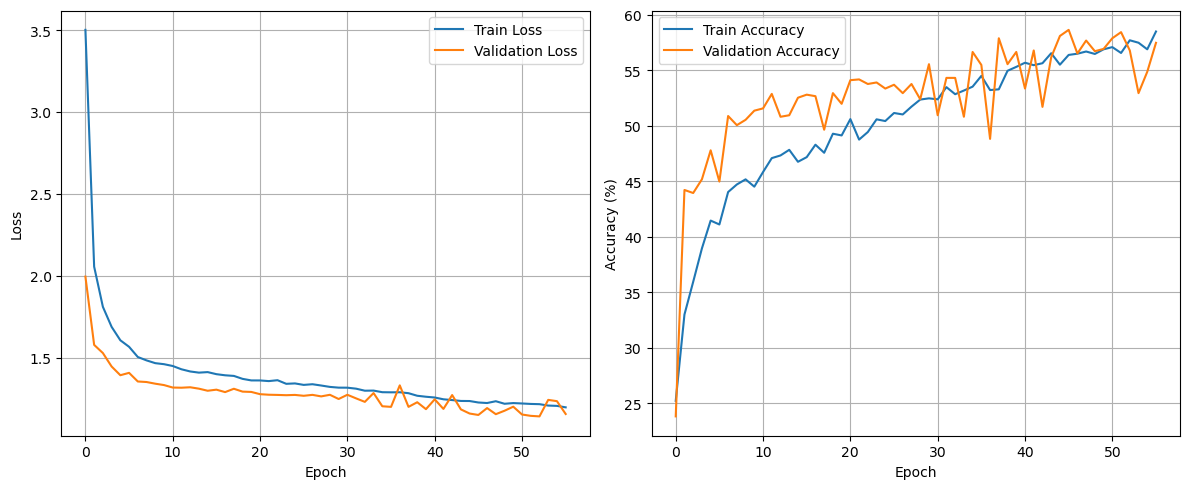

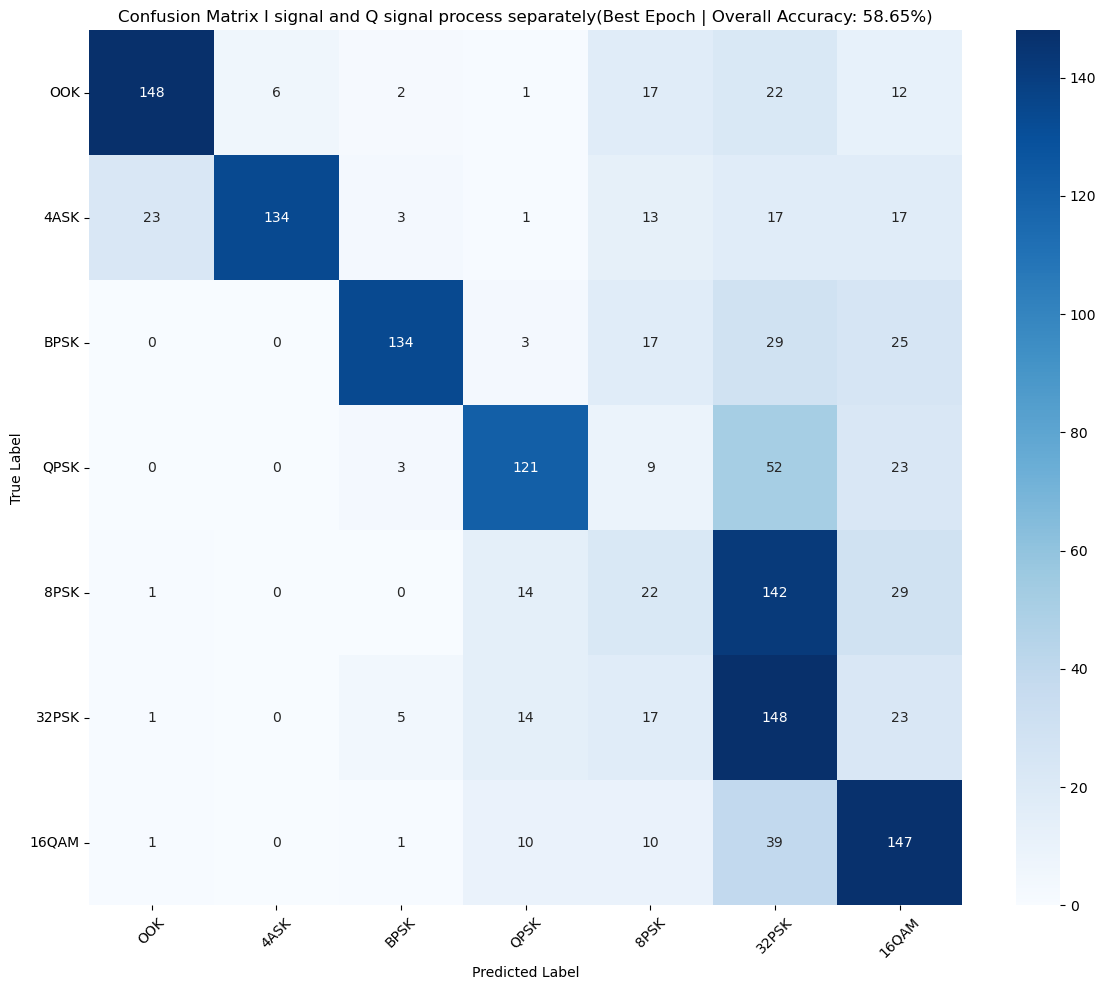

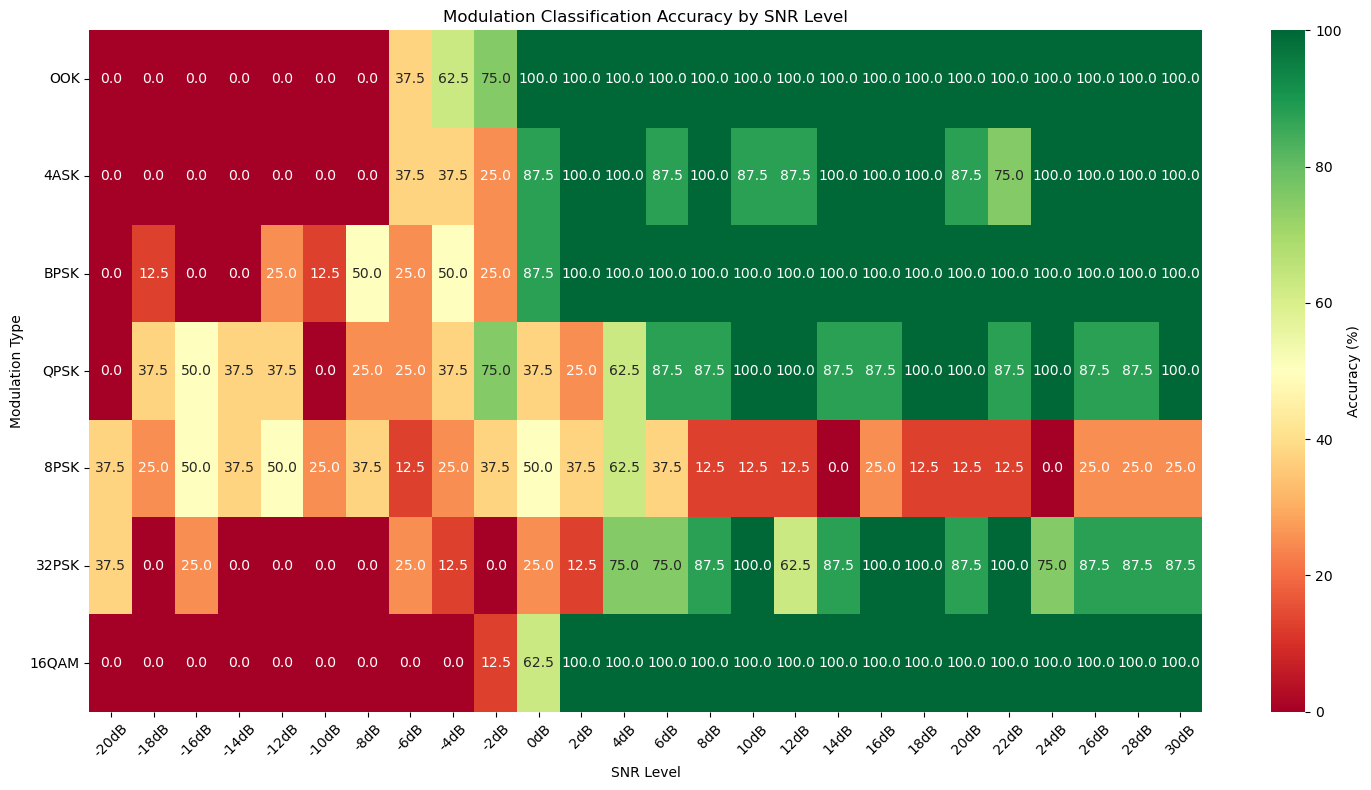

In [141]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Add label smoothing to reduce overfitting

optimizer = optim.AdamW(
    model_CNNIQ.parameters(), 
    lr=0.0015,  # Higher initial LR
    weight_decay=0.005,
    betas=(0.9, 0.999)
)

# Step scheduler
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[50, 100, 150], 
    gamma=0.5
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDataset('train', use_fft=False)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset = RadioMLIQDataset('train', use_fft=False)
valid_dataset = RadioMLIQDataset('valid', use_fft=False)  # Use separate valid split

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True,
    num_workers=2,  # Use some workers for faster loading
    persistent_workers=True
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    num_workers=2,
    persistent_workers=True
)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model_IQ.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_CNNIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_CNNIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_CNNIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix I signal and Q signal process separately(Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('best_confusion_matrix.png')
plt.show()

# --- Per-Modulation Accuracy Heatmap ---
def plot_modulation_snr_accuracy_heatmap(model, dataloader, device, target_modulations):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, snrs in dataloader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
    
    predictions_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    unique_snrs = sorted(predictions_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
    
    for i, mod in enumerate(target_modulations):
        for j, snr in enumerate(unique_snrs):
            subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
            if len(subset) > 0:
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(accuracy_matrix, 
                xticklabels=[f'{snr}dB' for snr in unique_snrs],
                yticklabels=target_modulations,
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.title('Modulation Classification Accuracy by SNR Level')
    plt.xlabel('SNR Level')
    plt.ylabel('Modulation Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    #plt.savefig('modulation_snr_accuracy_heatm.png')
    plt.show()

plot_modulation_snr_accuracy_heatmap(model_CNNIQ, valid_loader, device, TARGET_MODULATIONS)

/tmp/ipykernel_3185/1354366052.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
RadioMLIQDataset train: 4550 samples, 7 classes, 26 SNR levels
RadioMLIQDataset train: 4550 samples, 7 classes, 26 SNR levels
RadioMLIQDataset valid: 1456 samples, 7 classes, 26 SNR levels
Datasets loaded successfully.
Total dataset size: 4550
Train dataset size: 4550 (80%)
Validation dataset size: 1456 (20%)

Starting training...


Training:   0%|                      | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_3185/1354366052.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training:  56%|███████▏     | 20/36 [00:01<00:00, 19.73it/s]
                                                            
Validation:   0%|                    | 0/12 [00:00<?, ?it/s]
                                                            /home/lipplopp/anaconda3/envs/ai_sdr/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choo

Epoch 1/300: Train Loss: 1.4215 | Train Acc: 50.42% | Valid Loss: 1.8674 | Valid Acc: 32.83%



Training:  94%|████████████▎| 34/36 [00:02<00:00, 15.93it/s]
                                                            
Epochs:   1%|▏                                  | 2/300 [00:04<12:27,  2.51s/it]

Epoch 2/300: Train Loss: 1.3217 | Train Acc: 52.26% | Valid Loss: 1.7211 | Valid Acc: 34.00%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.54it/s]
                                                            
Epochs:   1%|▎                                  | 3/300 [00:07<12:45,  2.58s/it]

Epoch 3/300: Train Loss: 1.3285 | Train Acc: 52.18% | Valid Loss: 1.8724 | Valid Acc: 33.59%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.52it/s]
                                                            
Epochs:   1%|▍                                  | 4/300 [00:10<12:51,  2.61s/it]

Epoch 4/300: Train Loss: 1.3355 | Train Acc: 51.32% | Valid Loss: 1.8186 | Valid Acc: 33.10%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.50it/s]
                                                            
Epochs:   2%|▌                                  | 5/300 [00:12<12:58,  2.64s/it]

Epoch 5/300: Train Loss: 1.3035 | Train Acc: 52.79% | Valid Loss: 1.7043 | Valid Acc: 34.62%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.53it/s]
                                                            
Epochs:   2%|▋                                  | 6/300 [00:15<12:58,  2.65s/it]

Epoch 6/300: Train Loss: 1.2364 | Train Acc: 55.76% | Valid Loss: 1.1676 | Valid Acc: 57.76%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.51it/s]
                                                            
Epochs:   2%|▊                                  | 7/300 [00:18<12:56,  2.65s/it]

Epoch 7/300: Train Loss: 1.2829 | Train Acc: 54.15% | Valid Loss: 1.6635 | Valid Acc: 38.05%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.50it/s]
                                                            
Epochs:   3%|▉                                  | 8/300 [00:20<12:55,  2.65s/it]

Epoch 8/300: Train Loss: 1.2426 | Train Acc: 55.80% | Valid Loss: 1.1700 | Valid Acc: 57.69%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.51it/s]
                                                            
Epochs:   3%|█                                  | 9/300 [00:23<12:53,  2.66s/it]

Epoch 9/300: Train Loss: 1.2655 | Train Acc: 54.64% | Valid Loss: 1.5306 | Valid Acc: 42.86%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.51it/s]
                                                            
Epochs:   3%|█▏                                | 10/300 [00:26<12:50,  2.66s/it]

Epoch 10/300: Train Loss: 1.2951 | Train Acc: 52.97% | Valid Loss: 1.8940 | Valid Acc: 33.86%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.49it/s]
                                                            
Epochs:   4%|█▏                                | 11/300 [00:28<12:48,  2.66s/it]

Epoch 11/300: Train Loss: 1.2526 | Train Acc: 55.21% | Valid Loss: 1.4853 | Valid Acc: 43.96%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.50it/s]
                                                            
Epochs:   4%|█▎                                | 12/300 [00:31<12:45,  2.66s/it]

Epoch 12/300: Train Loss: 1.2612 | Train Acc: 54.07% | Valid Loss: 1.8492 | Valid Acc: 32.90%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.51it/s]
                                                            
Epochs:   4%|█▍                                | 13/300 [00:34<12:43,  2.66s/it]

Epoch 13/300: Train Loss: 1.2199 | Train Acc: 56.35% | Valid Loss: 1.8518 | Valid Acc: 33.10%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.50it/s]
                                                            
Epochs:   5%|█▌                                | 14/300 [00:36<12:40,  2.66s/it]

Epoch 14/300: Train Loss: 1.2607 | Train Acc: 54.44% | Valid Loss: 1.9342 | Valid Acc: 32.76%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.49it/s]
                                                            
Epochs:   5%|█▋                                | 15/300 [00:39<12:38,  2.66s/it]

Epoch 15/300: Train Loss: 1.2658 | Train Acc: 54.73% | Valid Loss: 1.8621 | Valid Acc: 33.93%



Training:  89%|███████████▌ | 32/36 [00:02<00:00, 15.50it/s]
                                                            
Epochs:   5%|█▋                                | 15/300 [00:42<13:22,  2.82s/it]

Early stopping at epoch 16

Training complete.
Best validation accuracy: 57.76%


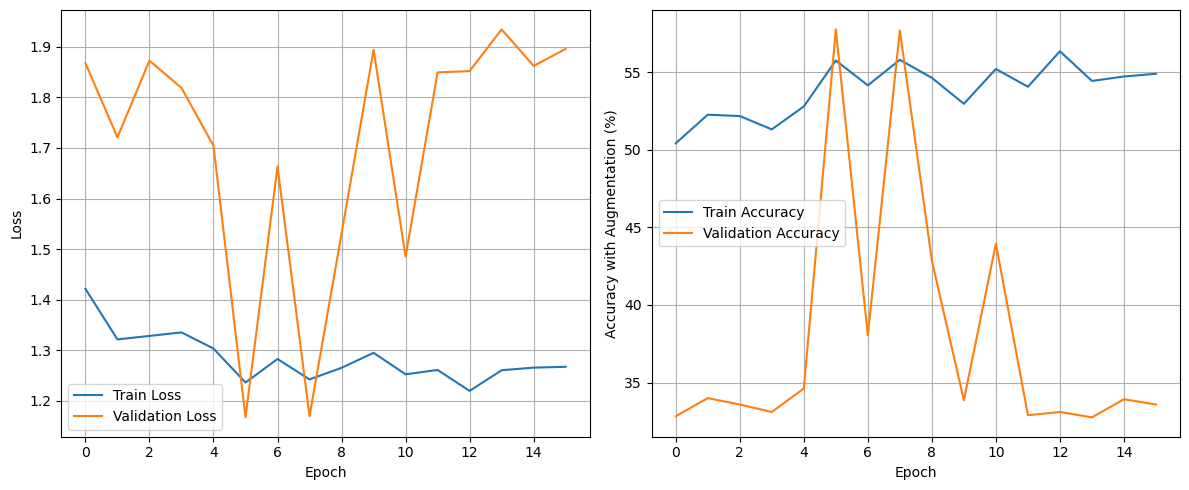

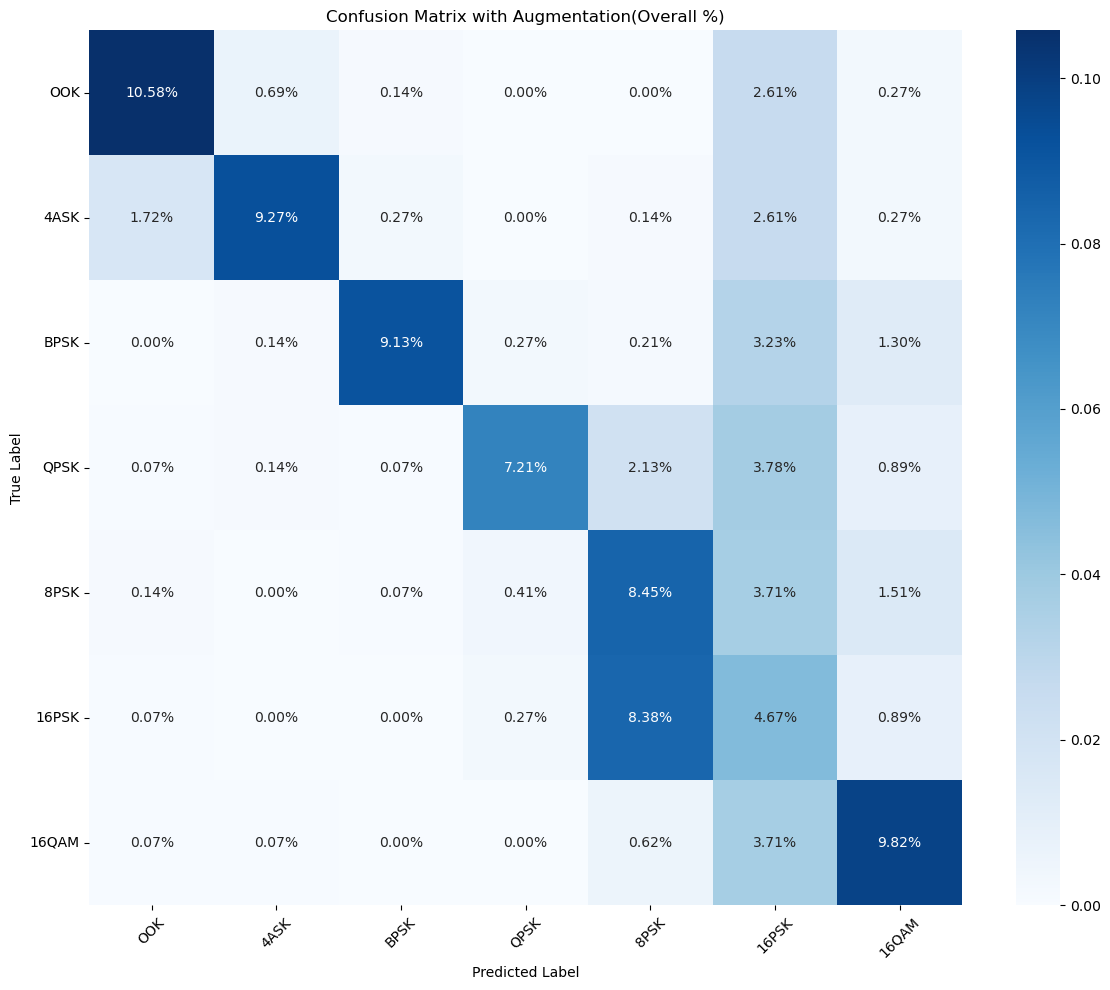

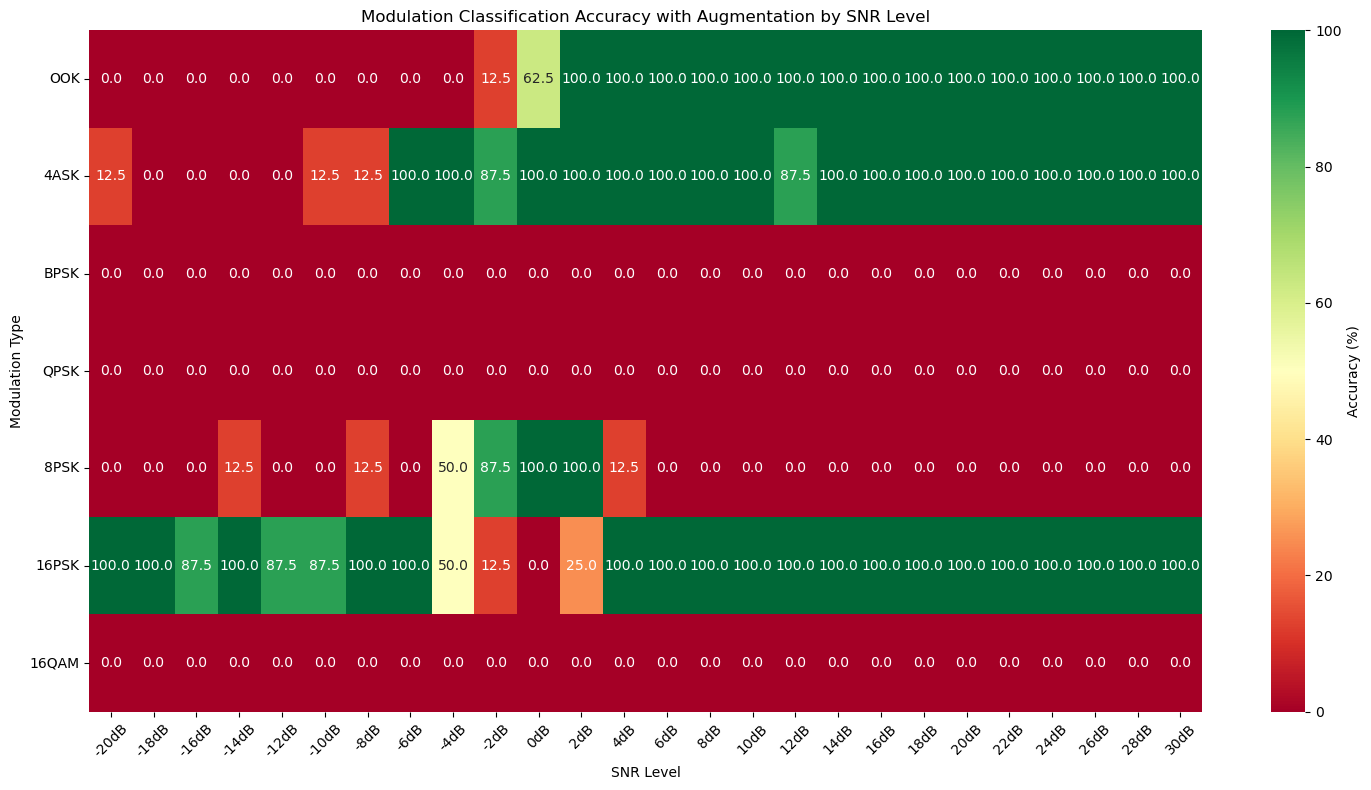

In [134]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Add label smoothing to reduce overfitting

optimizer = optim.AdamW(
    model_CNNIQ.parameters(), 
    lr=0.0003,  # Even lower
    weight_decay=0.005,  # Lighter regularization
    betas=(0.9, 0.999)
)


scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=NUM_EPOCHS, eta_min=1e-6
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDataset('train', use_fft=False)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset = RadioMLIQDataset('train', use_fft=False)
valid_dataset = RadioMLIQDataset('valid', use_fft=False)  # Use separate valid split

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True,
    num_workers=2,  # Use some workers for faster loading
    persistent_workers=True
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    num_workers=2,
    persistent_workers=True
)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model_IQ.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_CNNIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        # === INLINE SIGNAL AUGMENTATION ===
        # Apply augmentation only during training
        if model_CNNIQ.training:
            batch_size = i_inputs.size(0)
            
            # 1. Add very small Gaussian noise (20% chance only)
            if torch.rand(1) > 0.8:
                noise_std = 0.005  # Much smaller noise
                i_inputs += torch.randn_like(i_inputs) * noise_std
                q_inputs += torch.randn_like(q_inputs) * noise_std
            
            # 2. Very small amplitude scaling (15% chance only)
            if torch.rand(1) > 0.85:
                scale = torch.empty(batch_size, 1, 1, 1).uniform_(0.95, 1.05).to(device)  # Much smaller range
                i_inputs *= scale
                q_inputs *= scale
            
            # 3. Phase rotation for I/Q signals (25% chance)
            if torch.rand(1) > 0.75:
                # Random phase shifts between -0.1 to 0.1 radians
                phase_shift = torch.empty(batch_size, 1, 1, 1).uniform_(-0.1, 0.1).to(device)
                
                # Apply rotation: [I', Q'] = [cos(θ) -sin(θ); sin(θ) cos(θ)] * [I; Q]
                cos_shift = torch.cos(phase_shift)
                sin_shift = torch.sin(phase_shift)
                
                i_rotated = i_inputs * cos_shift - q_inputs * sin_shift
                q_rotated = i_inputs * sin_shift + q_inputs * cos_shift
                
                i_inputs = i_rotated
                q_inputs = q_rotated
            
            # 4. Random amplitude/phase swapping (15% chance)
            if torch.rand(1) > 0.85:
                # Swap I and Q channels randomly for some samples
                swap_mask = torch.rand(batch_size, 1, 1, 1) > 0.5
                swap_mask = swap_mask.to(device)
                
                i_temp = i_inputs.clone()
                i_inputs = torch.where(swap_mask, q_inputs, i_inputs)
                q_inputs = torch.where(swap_mask, i_temp, q_inputs)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_CNNIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_CNNIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy with Augmentation (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm_overall = cm.astype(float) / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_overall,
    annot=True,
    fmt=".2%",
    cmap="Blues",
    xticklabels=TARGET_MODULATIONS,
    yticklabels=TARGET_MODULATIONS
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with Augmentation(Overall %)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Per-Modulation Accuracy Heatmap ---
def plot_modulation_snr_accuracy_heatmap(model, dataloader, device, target_modulations):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, snrs in dataloader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
    
    predictions_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    unique_snrs = sorted(predictions_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
    
    for i, mod in enumerate(target_modulations):
        for j, snr in enumerate(unique_snrs):
            subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
            if len(subset) > 0:
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(accuracy_matrix, 
                xticklabels=[f'{snr}dB' for snr in unique_snrs],
                yticklabels=target_modulations,
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.title('Modulation Classification Accuracy with Augmentation by SNR Level')
    plt.xlabel('SNR Level')
    plt.ylabel('Modulation Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    #plt.savefig('modulation_snr_accuracy_heatm.png')
    plt.show()

plot_modulation_snr_accuracy_heatmap(model_CNNIQ, valid_loader, device, TARGET_MODULATIONS)